
### 🔹 1. Importing Required Libraries 

In [40]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt

###  🔹 2. Loading Data


In [41]:
df = pd.read_csv('/Users/egetamci/Desktop/Energy_Power/solar_battery_data.csv')  # Ensure the CSV contains 'time', 'Price', 'Solar' columns
time_series = df.to_dict('records')
time_series

[{'T': 1, 'Hour': 1, 'Interval': 1, 'Price': 12.77, 'Solar': 0.0},
 {'T': 2, 'Hour': 1, 'Interval': 2, 'Price': 11.82, 'Solar': 0.0},
 {'T': 3, 'Hour': 1, 'Interval': 3, 'Price': 12.39, 'Solar': 0.0},
 {'T': 4, 'Hour': 1, 'Interval': 4, 'Price': 10.17, 'Solar': 0.0},
 {'T': 5, 'Hour': 2, 'Interval': 1, 'Price': 5.86, 'Solar': 0.0},
 {'T': 6, 'Hour': 2, 'Interval': 2, 'Price': 2.69, 'Solar': 0.0},
 {'T': 7, 'Hour': 2, 'Interval': 3, 'Price': 1.46, 'Solar': 0.0},
 {'T': 8, 'Hour': 2, 'Interval': 4, 'Price': 1.41, 'Solar': 0.0},
 {'T': 9, 'Hour': 3, 'Interval': 1, 'Price': 0.03, 'Solar': 0.0},
 {'T': 10, 'Hour': 3, 'Interval': 2, 'Price': -0.19, 'Solar': 0.0},
 {'T': 11, 'Hour': 3, 'Interval': 3, 'Price': -0.72, 'Solar': 0.0},
 {'T': 12, 'Hour': 3, 'Interval': 4, 'Price': -0.54, 'Solar': 0.0},
 {'T': 13, 'Hour': 4, 'Interval': 1, 'Price': -0.45, 'Solar': 0.0},
 {'T': 14, 'Hour': 4, 'Interval': 2, 'Price': -0.6, 'Solar': 0.0},
 {'T': 15, 'Hour': 4, 'Interval': 3, 'Price': -0.72, 'Solar': 0

###  🔹 3. Model Parameters


In [43]:
solar_cap = 50       # Solar capacity in MW (DC)
battery_power = 10   # Battery charge/discharge power in MW (DC)
battery_energy = 40  # Battery capacity in MWh
grid_cap = 40        # Grid export/import capacity in MW (AC)
battery_eff = 0.95   # Battery round-trip efficiency
inverter_eff = 0.9   # Inverter DC/AC efficiency
start_soc = 20       # Initial state of charge (MWh)
n_periods = len(time_series)

###  🔹 4. Model Definition

In [44]:
model = gp.Model("SolarBatteryOptimization")


###  🔹 5. Decision Variables


In [45]:
solar = model.addVars(n_periods, ub=solar_cap, name="Solar")
charge = model.addVars(n_periods, ub=battery_power, name="Charge")
discharge = model.addVars(n_periods, ub=battery_power, name="Discharge")
grid_export = model.addVars(n_periods, ub=grid_cap, name="GridExport")
grid_import = model.addVars(n_periods, ub=grid_cap, name="GridImport")
soc = model.addVars(n_periods, ub=battery_energy, name="SOC")

### 🔹 6. Constraints on Power Network Parameters

In [46]:
# Energy Balance Constraint
for t in range(n_periods):
    model.addConstr(
        solar[t] + discharge[t] - charge[t] == 
        grid_export[t] / inverter_eff - grid_import[t] * inverter_eff,
        name=f"energy_balance_{t}"
    )

# Battery Dynamics
model.addConstr(
    soc[0] == start_soc + (charge[0] * battery_eff - discharge[0] / battery_eff) * 0.25,
    name="initial_soc"
)

for t in range(1, n_periods):
    model.addConstr(
        soc[t] == soc[t-1] + (charge[t] * battery_eff - discharge[t] / battery_eff) * 0.25,
        name=f"soc_dynamics_{t}"
    )

# Solar Generation Limit
for t in range(n_periods):
    model.addConstr(
        solar[t] <= time_series[t]['Solar'],
        name=f"solar_limit_{t}"
    )


### 🔹 7. Objective Function (Maximizing Revenue)

In [47]:

revenue = gp.quicksum(
    (grid_export[t] - grid_import[t]) * time_series[t]['Price'] * 0.25 
    for t in range(n_periods)
)
model.setObjective(revenue, GRB.MAXIMIZE)

### 🔹 8. Optimization

In [48]:
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 288 rows, 576 columns and 959 nonzeros
Model fingerprint: 0x4a5d5fd7
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-03, 2e+01]
  Bounds range     [1e+01, 5e+01]
  RHS range        [8e-02, 5e+01]
Presolve removed 103 rows and 112 columns
Presolve time: 0.17s
Presolved: 185 rows, 464 columns, 744 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4673690e+04   3.735941e+02   0.000000e+00      0s
     194    7.2909610e+03   0.000000e+00   0.000000e+00      0s

Solved in 194 iterations and 0.25 seconds (0.00 work units)
Optimal objective  7.290960979e+03


### 🔹 9. Results Extraction

In [49]:

results = pd.DataFrame({
    'Period': range(1, n_periods+1),
    'Price': [ts['Price'] for ts in time_series],
    'Solar': [solar[t].X for t in range(n_periods)],
    'Charge': [charge[t].X for t in range(n_periods)],
    'Discharge': [discharge[t].X for t in range(n_periods)],
    'SOC': [soc[t].X for t in range(n_periods)],
    'Export': [grid_export[t].X for t in range(n_periods)],
    'Import': [grid_import[t].X for t in range(n_periods)],
})

### 🔹 10. Visualization

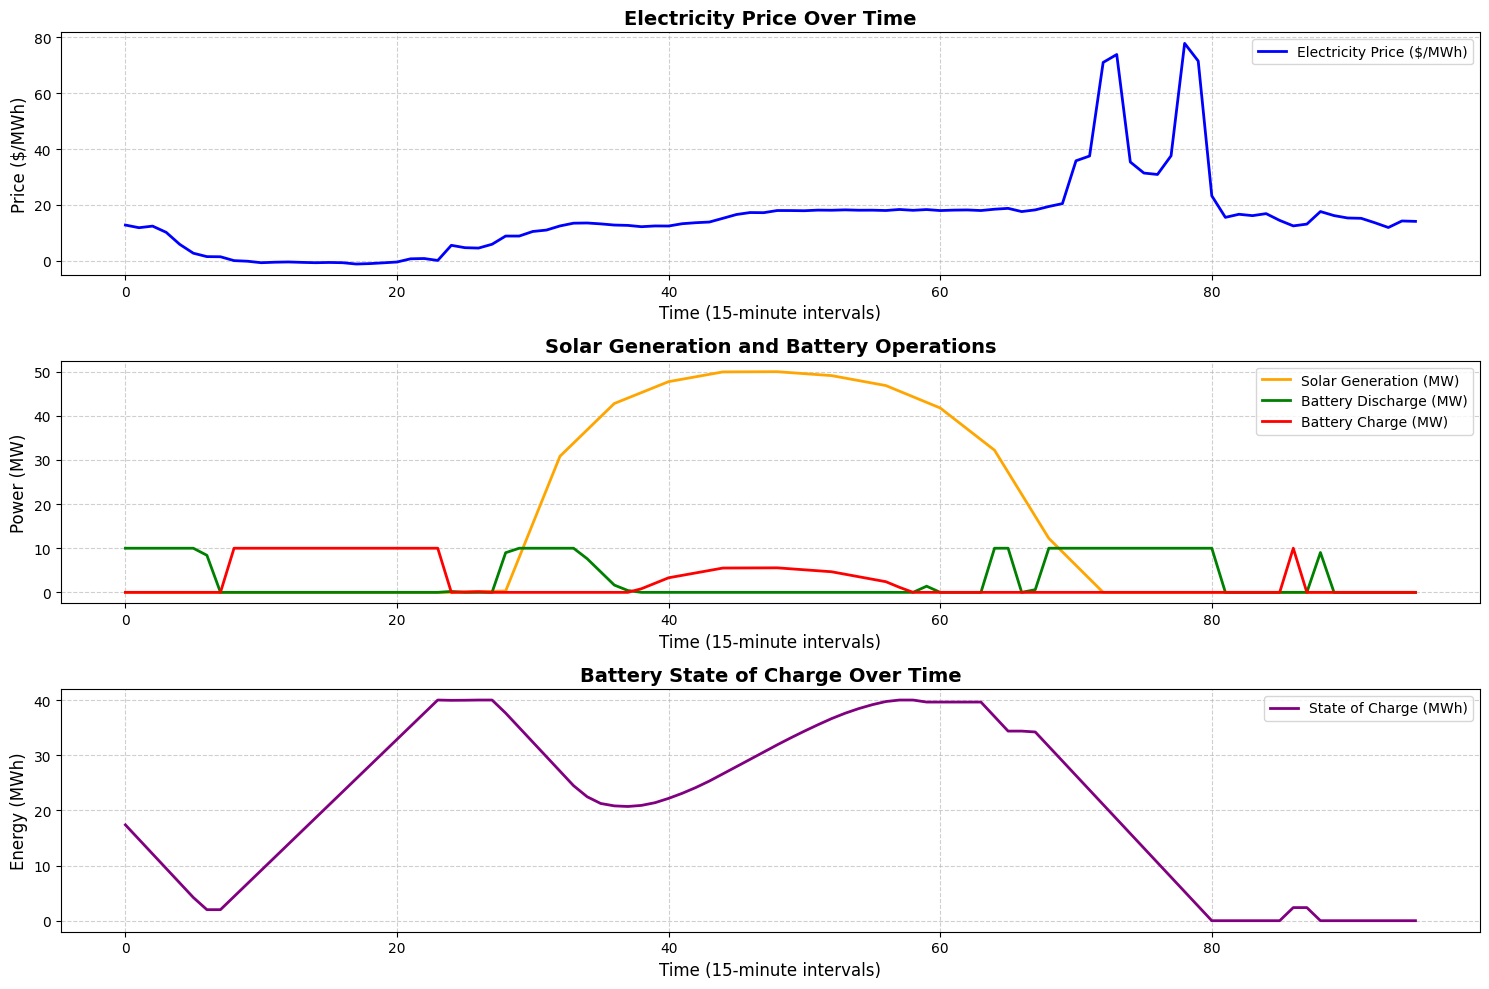

In [52]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
plt.figure(figsize=(15, 10))

# Subplot 1: Electricity Price
plt.subplot(3, 1, 1)
plt.plot(results['Price'], label='Electricity Price ($/MWh)', color='blue', linewidth=2)
plt.title('Electricity Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time (15-minute intervals)', fontsize=12)
plt.ylabel('Price ($/MWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)

# Subplot 2: Solar Generation and Battery Operations
plt.subplot(3, 1, 2)
plt.plot(results['Solar'], label='Solar Generation (MW)', color='orange', linewidth=2)
plt.plot(results['Discharge'], label='Battery Discharge (MW)', color='green', linewidth=2)
plt.plot(results['Charge'], label='Battery Charge (MW)', color='red', linewidth=2)
plt.title('Solar Generation and Battery Operations', fontsize=14, fontweight='bold')
plt.xlabel('Time (15-minute intervals)', fontsize=12)
plt.ylabel('Power (MW)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)

# Subplot 3: State of Charge (SOC)
plt.subplot(3, 1, 3)
plt.plot(results['SOC'], label='State of Charge (MWh)', color='purple', linewidth=2)
plt.title('Battery State of Charge Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time (15-minute intervals)', fontsize=12)
plt.ylabel('Energy (MWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure (optional)
plt.savefig('energy_operations_analysis.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### 🔹 11. Revenue Calculation

In [51]:

total_revenue = sum((results['Export'] - results['Import']) * results['Price'] * 0.25)
print(f"Total Revenue: ${total_revenue:.2f}")

Total Revenue: $7290.96
